# Differences according to the number of patches

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('./result/c-index result.xlsx', usecols=['c-index', 'num_patch'])
df.rename(columns  = {'num_patch': 'The number of patches'}, inplace = True)
df

,c-index,The number of patches
0,0.685446,2
1,0.696882,2
2,0.717468,2
3,0.722273,2
4,0.770492,2
...,...,...
395,0.701123,9
396,0.734011,9
397,0.744052,9
398,0.717175,9


In [2]:
df.groupby('The number of patches').median()

,c-index
The number of patches,
2,0.715260
3,0.722163
4,0.719435
5,0.721602
6,0.723779
7,0.718571
8,0.720758
9,0.721696


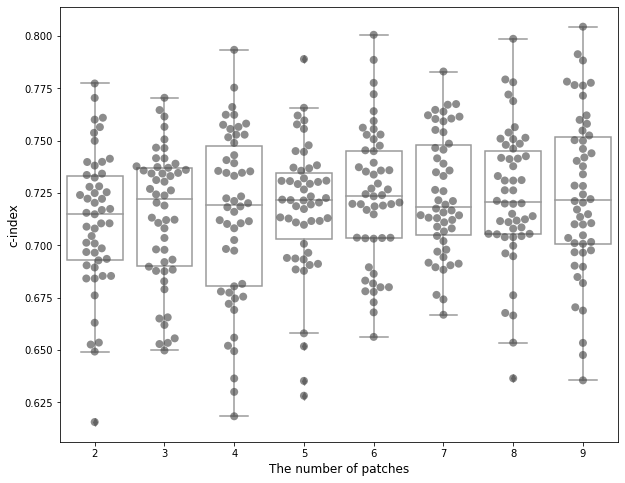

In [3]:
import seaborn as sns
plt.rcParams["axes.labelsize"] = 12
plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = "The number of patches", y = "c-index", data = df, color = 'white')
ax = sns.swarmplot(x = "The number of patches", y = "c-index", data = df, color = ".25", alpha = 0.6, size = 8)
plt.show()

In [4]:
from scipy.stats import wilcoxon, kruskal

wilcoxon(df.loc[df['The number of patches'] == 2, 'c-index'],
         df.loc[df['The number of patches'] == 6, 'c-index'],
         alternative = 'two-sided')

WilcoxonResult(statistic=522.0, pvalue=0.2648702686053157)

In [5]:
kruskal(df.loc[df['The number of patches'] == 2, 'c-index'],
        df.loc[df['The number of patches'] == 3, 'c-index'],
        df.loc[df['The number of patches'] == 4, 'c-index'],
        df.loc[df['The number of patches'] == 5, 'c-index'],
        df.loc[df['The number of patches'] == 6, 'c-index'])

KruskalResult(statistic=2.5557953784860956, pvalue=0.6346734033947952)

# Difference between the proposed method and the simple aggregation method

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel('./result/simple aggregation.xlsx')
df = df.melt(var_name='method', value_name='c-index')
df.head()

,method,c-index
0,average aggregation,0.696554
1,average aggregation,0.681861
2,average aggregation,0.716031
3,average aggregation,0.718538
4,average aggregation,0.700376


In [15]:
df.groupby('method').std()

,c-index
method,
average aggregation,0.037101
max aggregation,0.038751
min aggregation,0.037084
ours,0.030978


average aggregation v.s. ours: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.120e-08 U_stat=4.210e+02


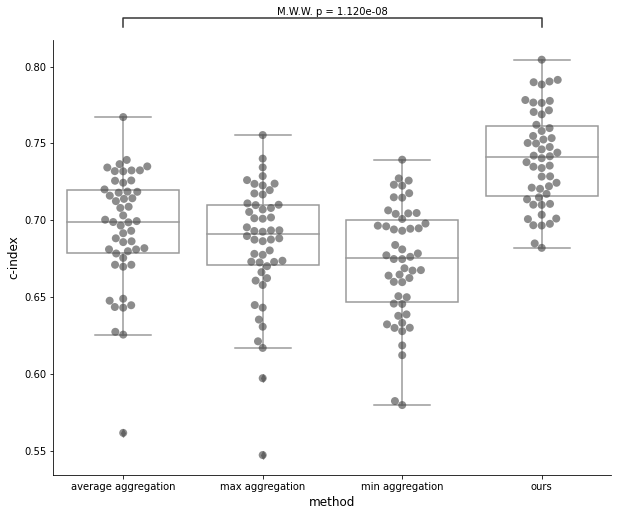

In [8]:
from statannot import add_stat_annotation

plt.rcParams["axes.labelsize"] = 12
fig = plt.figure(figsize = (10, 8))
ax = sns.boxplot(x = "method", y = "c-index", data = df, color = 'white')
ax = sns.swarmplot(x = "method", y = "c-index", data = df, color = ".25", alpha = 0.6, size = 8)
ax, test_results = add_stat_annotation(ax, data=df, x='method', y='c-index',
                                        box_pairs=[('average aggregation', 'ours')],
                                        test='Mann-Whitney', text_format='full', loc='outside', verbose=2)
sns.despine()
plt.show()

In [9]:
fig.savefig('fig4.png',dpi = 300, bbox_inches='tight', pad_inches = 0.1)

# K-M plot

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision import transforms

from datasets import LoadData, ImageDataset

ds = LoadData('./data')
dataset = ds.load_dataset(interval='year')
dataset

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype
0,TCGA-02-0001,0,0.980822,4.0,44,IDHwt
1,TCGA-02-0003,0,0.394521,4.0,50,IDHwt
2,TCGA-02-0006,0,1.528767,4.0,56,IDHwt
3,TCGA-02-0007,0,1.931507,4.0,40,IDHwt
4,TCGA-02-0009,0,0.882192,4.0,61,IDHwt
...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,3.616438,NaN,20,IDHmut-non-codel
765,TCGA-WY-A85B,1,3.816438,NaN,24,IDHmut-non-codel
766,TCGA-WY-A85C,1,3.906849,NaN,36,IDHmut-non-codel
767,TCGA-WY-A85D,1,3.142466,NaN,60,IDHmut-non-codel


In [10]:
dataset.replace({'Molecular subtype' : {'IDHwt' : 'IDH wild-type astrocytoma',
                                       'IDHmut-non-codel' : 'IDH mutant astrocytoma',
                                       'IDHmut-codel' : 'Oligodendroglioma'}},
               inplace=True)
dataset.replace({'Grade' : {2 : '2', 3 : '3', 4 : '4'}},
               inplace=True)
dataset

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype
0,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma
1,TCGA-02-0003,0,0.394521,4,50,IDH wild-type astrocytoma
2,TCGA-02-0006,0,1.528767,4,56,IDH wild-type astrocytoma
3,TCGA-02-0007,0,1.931507,4,40,IDH wild-type astrocytoma
4,TCGA-02-0009,0,0.882192,4,61,IDH wild-type astrocytoma
...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,3.616438,NaN,20,IDH mutant astrocytoma
765,TCGA-WY-A85B,1,3.816438,NaN,24,IDH mutant astrocytoma
766,TCGA-WY-A85C,1,3.906849,NaN,36,IDH mutant astrocytoma
767,TCGA-WY-A85D,1,3.142466,NaN,60,IDH mutant astrocytoma


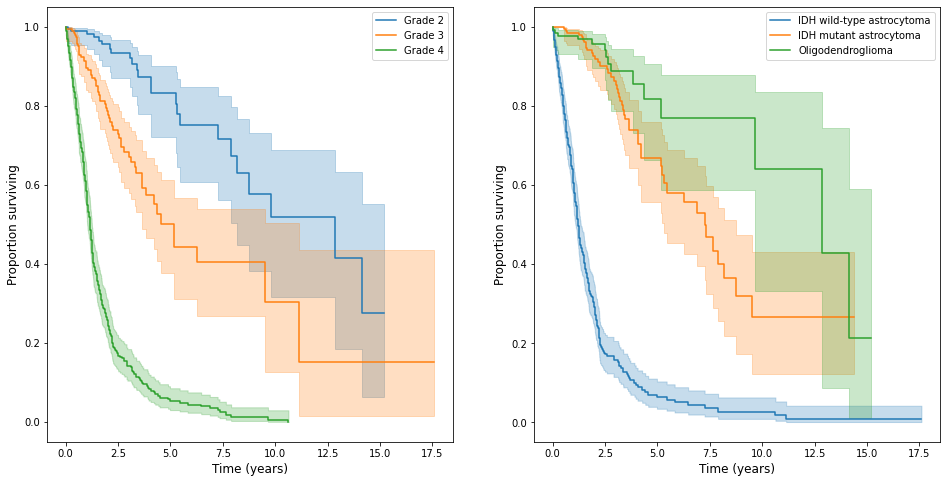

In [11]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter(alpha = 0.05)
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

kmf.fit(durations = dataset.loc[dataset['Grade'] == '2', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Grade'] == '2', :]['censored'], label = 'Grade 2')
ax1 = kmf.plot(ax = ax1)
kmf.fit(durations = dataset.loc[dataset['Grade'] == '3', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Grade'] == '3', :]['censored'], label = 'Grade 3')
ax1 = kmf.plot(ax = ax1)
kmf.fit(durations = dataset.loc[dataset['Grade'] == '4', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Grade'] == '4', :]['censored'], label = 'Grade 4')
ax1 = kmf.plot(ax = ax1)
ax1.set_ylabel('Proportion surviving')
ax1.set_xlabel('Time (years)')

kmf.fit(durations = dataset.loc[dataset['Molecular subtype'] == 'IDH wild-type astrocytoma', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Molecular subtype'] == 'IDH wild-type astrocytoma', :]['censored'], label = 'IDH wild-type astrocytoma')
ax2 = kmf.plot(ax = ax2)

kmf.fit(durations = dataset.loc[dataset['Molecular subtype'] == 'IDH mutant astrocytoma', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Molecular subtype'] == 'IDH mutant astrocytoma', :]['censored'], label = 'IDH mutant astrocytoma')
ax2 = kmf.plot(ax = ax2)

kmf.fit(durations = dataset.loc[dataset['Molecular subtype'] == 'Oligodendroglioma', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Molecular subtype'] == 'Oligodendroglioma', :]['censored'], label = 'Oligodendroglioma')
ax2 = kmf.plot(ax = ax2)
ax2.set_ylabel('Proportion surviving')
ax2.set_xlabel('Time (years)')

plt.show()

# Prediction

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision import transforms

from datasets import LoadData, ImageDataset

ds = LoadData('./data')

In [2]:
dataset = ds.load_dataset(interval='year')
dataset

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype
0,TCGA-02-0001,0,0.980822,4.0,44,IDHwt
1,TCGA-02-0003,0,0.394521,4.0,50,IDHwt
2,TCGA-02-0006,0,1.528767,4.0,56,IDHwt
3,TCGA-02-0007,0,1.931507,4.0,40,IDHwt
4,TCGA-02-0009,0,0.882192,4.0,61,IDHwt
...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,3.616438,NaN,20,IDHmut-non-codel
765,TCGA-WY-A85B,1,3.816438,NaN,24,IDHmut-non-codel
766,TCGA-WY-A85C,1,3.906849,NaN,36,IDHmut-non-codel
767,TCGA-WY-A85D,1,3.142466,NaN,60,IDHmut-non-codel


In [3]:
dataset.replace({'Molecular subtype' : {'IDHwt' : 'IDH wild-type astrocytoma',
                                       'IDHmut-non-codel' : 'IDH mutant astrocytoma',
                                       'IDHmut-codel' : 'Oligodendroglioma'}},
               inplace=True)
dataset.replace({'Grade' : {2 : '2', 3 : '3', 4 : '4'}},
               inplace=True)

In [4]:
dataset

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype
0,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma
1,TCGA-02-0003,0,0.394521,4,50,IDH wild-type astrocytoma
2,TCGA-02-0006,0,1.528767,4,56,IDH wild-type astrocytoma
3,TCGA-02-0007,0,1.931507,4,40,IDH wild-type astrocytoma
4,TCGA-02-0009,0,0.882192,4,61,IDH wild-type astrocytoma
...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,3.616438,NaN,20,IDH mutant astrocytoma
765,TCGA-WY-A85B,1,3.816438,NaN,24,IDH mutant astrocytoma
766,TCGA-WY-A85C,1,3.906849,NaN,36,IDH mutant astrocytoma
767,TCGA-WY-A85D,1,3.142466,NaN,60,IDH mutant astrocytoma


In [5]:
full_df = dataset.merge(ds.load_image(), on = 'TCGA ID')
full_df

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Filename
0,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
1,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
2,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
3,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
4,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
...,...,...,...,...,...,...,...
13933,TCGA-WY-A85E,1,1.734247,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13934,TCGA-WY-A85E,1,1.734247,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13935,TCGA-WY-A85E,1,1.734247,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13936,TCGA-WY-A85E,1,1.734247,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...


In [6]:
image_path = './data/all_st_patches_512'
SAMPLE_SIZE = 9
full_dataset = ImageDataset(dataframe = full_df, root_dir = image_path, sample_size = SAMPLE_SIZE,
                            transform = transforms.Compose([transforms.Resize(224),
                                                            transforms.ToTensor()]),
                            random_state=1234)

print(full_dataset[0]['image'].shape)

torch.Size([9, 3, 224, 224])


In [7]:
BATCH_SIZE = 8
full_loader = DataLoader(full_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [8]:
import tqdm
import torch

def predictor(model, data_loader, device):
    model.eval()
    survtime_preds = []
    for sample_batch in tqdm.tqdm(data_loader, total=len(data_loader)):
        image_batch = sample_batch['image']
        image_batch = image_batch.to(device, dtype=torch.float)

        with torch.no_grad():
            survtime_preds_batch = model(image_batch)
        survtime_preds.append(survtime_preds_batch)
    survtime_preds = torch.cat(survtime_preds)

    return survtime_preds

In [9]:
from models import Model
from models import PretrainNet

pretrain_model = PretrainNet()
model = Model(pretrain_model, sample_size =SAMPLE_SIZE)

In [10]:
model.load_state_dict(torch.load('final_model2.pt'))
model.to('cuda:0')

Model(
  (pretrain_cnn_model): PretrainNet(
    (ConvNet): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pad

In [11]:
prediction = predictor(model, full_loader, 'cuda:0')

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [01:23<00:00,  1.16it/s]


In [12]:
import numpy as np

#dataset['Hazard'] = np.exp(prediction.to('cpu').numpy())
dataset['Hazard'] = prediction.to('cpu').numpy()
dataset['Hazard (z-scored)'] = (dataset['Hazard'] - dataset['Hazard'].mean()) / dataset['Hazard'].std()
dataset

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Hazard,Hazard (z-scored)
0,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma,1.471659,0.464432
1,TCGA-02-0003,0,0.394521,4,50,IDH wild-type astrocytoma,2.577815,1.423819
2,TCGA-02-0006,0,1.528767,4,56,IDH wild-type astrocytoma,1.353360,0.361830
3,TCGA-02-0007,0,1.931507,4,40,IDH wild-type astrocytoma,1.610196,0.584588
4,TCGA-02-0009,0,0.882192,4,61,IDH wild-type astrocytoma,2.070483,0.983803
...,...,...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,3.616438,NaN,20,IDH mutant astrocytoma,-0.676734,-1.398903
765,TCGA-WY-A85B,1,3.816438,NaN,24,IDH mutant astrocytoma,1.859993,0.801241
766,TCGA-WY-A85C,1,3.906849,NaN,36,IDH mutant astrocytoma,0.678490,-0.223495
767,TCGA-WY-A85D,1,3.142466,NaN,60,IDH mutant astrocytoma,0.087827,-0.735787


In [13]:
import seaborn as sns
from statannot import add_stat_annotation

fig = plt.figure(figsize = (20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sns.boxplot(x='Grade', y='Hazard (z-scored)', data=dataset, ax=ax1, order=['2', '3', '4'])
ax1, test_results = add_stat_annotation(ax1, data=dataset, x='Grade', y='Hazard (z-scored)', order=['2', '3', '4'],
                                        box_pairs=[("2", "3"), ("2", "4"), ("3", "4")],
                                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2)


sns.boxplot(x='Molecular subtype', y='Hazard (z-scored)', data=dataset, ax=ax2)
ax2, test_results = add_stat_annotation(ax2, data=dataset, x='Molecular subtype', y='Hazard (z-scored)',
                                        order=['IDH wild-type astrocytoma', 'IDH mutant astrocytoma', 'Oligodendroglioma'],
                                        box_pairs=[("IDH wild-type astrocytoma", "IDH mutant astrocytoma"),
                                                   ("IDH wild-type astrocytoma", "Oligodendroglioma"),
                                                   ("IDH mutant astrocytoma", "Oligodendroglioma"),],
                                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#sns.despine() # 필요없는 axis border 제거
#ax1.set_title("First")
#ax2.set_title("Second")
#plt.suptitle("Main")
plt.show()

NameError: name 'plt' is not defined

In [55]:
#fig.savefig('fig4.png',dpi = 300, bbox_inches='tight',pad_inches = 0.1)

<AxesSubplot:xlabel='Molecular subtype', ylabel='Hazard (z-scored)'>

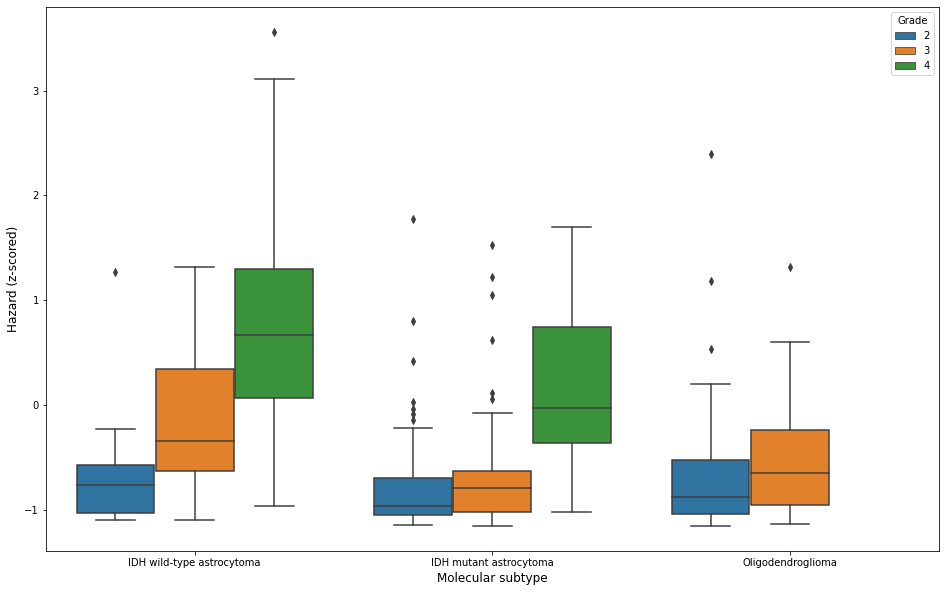

In [68]:
Oligodendroglioma = dataset[dataset['Molecular subtype'] == 'Oligodendroglioma']
Oligodendroglioma[Oligodendroglioma['Grade'] == '4'].index

dataset = dataset.drop(Oligodendroglioma[Oligodendroglioma['Grade'] == '4'].index, axis=0)

fig = plt.figure(figsize = (16, 10))
sns.boxplot(x='Molecular subtype', y='Hazard (z-scored)', data=dataset, hue='Grade',
            hue_order = ['2', '3', '4'])

In [26]:
qcut = pd.qcut(dataset['Hazard'].sort_values(), q=[0, 0.33, 0.66, 1], labels=['Low', 'Mid', 'High'])
qcut

724     Low
373     Low
352     Low
726     Low
696     Low
       ... 
243    High
272    High
20     High
76     High
332    High
Name: Hazard, Length: 769, dtype: category
Categories (3, object): ['Low' < 'Mid' < 'High']

In [27]:
dataset['cut'] = qcut
dataset

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Hazard,Hazard (z-scored),cut
0,TCGA-02-0001,0,0.980822,4,44,IDH wild-type astrocytoma,4.356455,0.037349,Mid
1,TCGA-02-0003,0,0.394521,4,50,IDH wild-type astrocytoma,13.168331,2.484947,High
2,TCGA-02-0006,0,1.528767,4,56,IDH wild-type astrocytoma,3.870408,-0.097655,Mid
3,TCGA-02-0007,0,1.931507,4,40,IDH wild-type astrocytoma,5.003793,0.217155,Mid
4,TCGA-02-0009,0,0.882192,4,61,IDH wild-type astrocytoma,7.928655,1.029568,High
...,...,...,...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,3.616438,NaN,20,IDH mutant astrocytoma,0.508274,-1.031526,Low
765,TCGA-WY-A85B,1,3.816438,NaN,24,IDH mutant astrocytoma,6.423689,0.611547,High
766,TCGA-WY-A85C,1,3.906849,NaN,36,IDH mutant astrocytoma,1.970900,-0.625265,Mid
767,TCGA-WY-A85D,1,3.142466,NaN,60,IDH mutant astrocytoma,1.091799,-0.869445,Low


Text(0, 0.5, 'Proportion surviving')

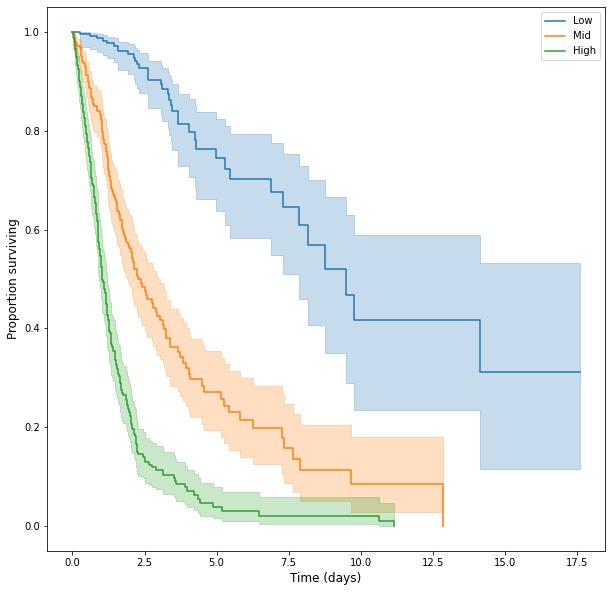

In [28]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter(alpha = 0.05)
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1)

kmf.fit(durations = dataset.loc[dataset['cut'] == 'Low', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['cut'] == 'Low', :]['censored'], label = 'Low')
ax1 = kmf.plot(ax = ax)
kmf.fit(durations = dataset.loc[dataset['cut'] == 'Mid', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['cut'] == 'Mid', :]['censored'], label = 'Mid')
ax1 = kmf.plot(ax = ax)
kmf.fit(durations = dataset.loc[dataset['cut'] == 'High', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['cut'] == 'High', :]['censored'], label = 'High')
ax1 = kmf.plot(ax = ax)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion surviving')

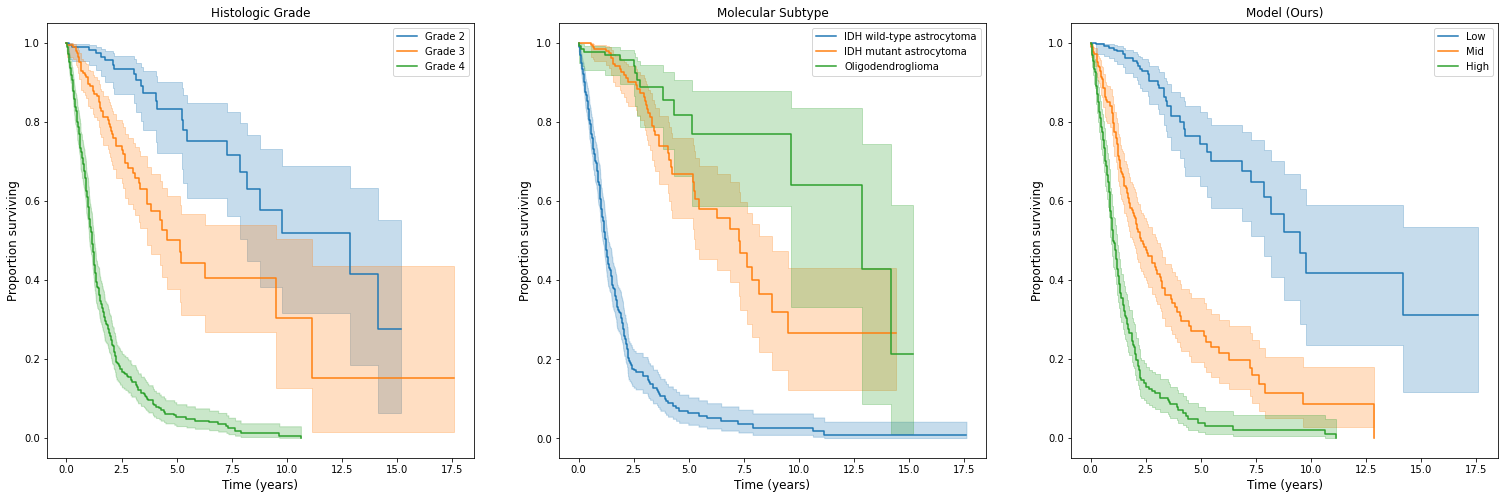

In [29]:
kmf = KaplanMeierFitter(alpha = 0.05)
fig = plt.figure(figsize = (26, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

kmf.fit(durations = dataset.loc[dataset['Grade'] == '2', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Grade'] == '2', :]['censored'], label = 'Grade 2')
ax1 = kmf.plot(ax = ax1)
kmf.fit(durations = dataset.loc[dataset['Grade'] == '3', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Grade'] == '3', :]['censored'], label = 'Grade 3')
ax1 = kmf.plot(ax = ax1)
kmf.fit(durations = dataset.loc[dataset['Grade'] == '4', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Grade'] == '4', :]['censored'], label = 'Grade 4')
ax1 = kmf.plot(ax = ax1)
ax1.set_ylabel('Proportion surviving')
ax1.set_xlabel('Time (years)')
ax1.set_title("Histologic Grade")

kmf.fit(durations = dataset.loc[dataset['Molecular subtype'] == 'IDH wild-type astrocytoma', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Molecular subtype'] == 'IDH wild-type astrocytoma', :]['censored'], label = 'IDH wild-type astrocytoma')
ax2 = kmf.plot(ax = ax2)

kmf.fit(durations = dataset.loc[dataset['Molecular subtype'] == 'IDH mutant astrocytoma', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Molecular subtype'] == 'IDH mutant astrocytoma', :]['censored'], label = 'IDH mutant astrocytoma')
ax2 = kmf.plot(ax = ax2)

kmf.fit(durations = dataset.loc[dataset['Molecular subtype'] == 'Oligodendroglioma', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['Molecular subtype'] == 'Oligodendroglioma', :]['censored'], label = 'Oligodendroglioma')
ax2 = kmf.plot(ax = ax2)
ax2.set_ylabel('Proportion surviving')
ax2.set_xlabel('Time (years)')
ax2.set_title("Molecular Subtype")



kmf.fit(durations = dataset.loc[dataset['cut'] == 'Low', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['cut'] == 'Low', :]['censored'], label = 'Low')
ax1 = kmf.plot(ax = ax3)
kmf.fit(durations = dataset.loc[dataset['cut'] == 'Mid', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['cut'] == 'Mid', :]['censored'], label = 'Mid')
ax1 = kmf.plot(ax = ax3)
kmf.fit(durations = dataset.loc[dataset['cut'] == 'High', :]['Survival months'],
        event_observed =  1-dataset.loc[dataset['cut'] == 'High', :]['censored'], label = 'High')
ax1 = kmf.plot(ax = ax3)
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Proportion surviving')
ax3.set_title("Model (Ours)")

plt.show()

In [30]:
#fig.savefig('fig5.png', dpi=300, bbox_inches='tight',pad_inches = 0.1)

In [31]:
from lifelines.statistics import logrank_test

results = logrank_test(dataset[dataset['cut'] == 'Low']['Survival months'], 
                       dataset[dataset['cut'] == 'Mid']['Survival months'], 
                       event_observed_A = 1-dataset[dataset['cut'] == 'Low']['censored'], 
                       event_observed_B = 1-dataset[dataset['cut'] == 'Mid']['censored'])

print(results.p_value) 
print(results.test_statistic)

3.740157571774702e-26
111.9094080440092


In [32]:
results = logrank_test(dataset[dataset['cut'] == 'Mid']['Survival months'], 
                       dataset[dataset['cut'] == 'High']['Survival months'], 
                       event_observed_A = 1-dataset[dataset['cut'] == 'Mid']['censored'], 
                       event_observed_B = 1-dataset[dataset['cut'] == 'High']['censored'])

print(results.p_value) 
print(results.test_statistic)

4.4070097965689455e-17
70.58569548513027


# sort hazards

In [35]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from torchvision import transforms

from datasets import LoadData, ImageDataset

ds = LoadData('./data')

In [36]:
dataset = ds.load_dataset(interval='day')

In [37]:
dataset.replace({'Molecular subtype' : {'IDHwt' : 'IDH wild-type astrocytoma',
                                       'IDHmut-non-codel' : 'IDH mutant astrocytoma',
                                       'IDHmut-codel' : 'Oligodendroglioma'}},
               inplace=True)
dataset.replace({'Grade' : {2 : '2', 3 : '3', 4 : '4'}},
               inplace=True)

In [38]:
full_df = dataset.merge(ds.load_image(), on = 'TCGA ID')
full_df

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Filename
0,TCGA-02-0001,0,358,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
1,TCGA-02-0001,0,358,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
2,TCGA-02-0001,0,358,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
3,TCGA-02-0001,0,358,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
4,TCGA-02-0001,0,358,4,44,IDH wild-type astrocytoma,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b15...
...,...,...,...,...,...,...,...
13933,TCGA-WY-A85E,1,633,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13934,TCGA-WY-A85E,1,633,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13935,TCGA-WY-A85E,1,633,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...
13936,TCGA-WY-A85E,1,633,NaN,48,IDH mutant astrocytoma,TCGA-WY-A85E-01Z-00-DX1.AA7A4C1F-99AA-490D-B6D...


In [34]:
dataset.sort_values(by='Hazard (z-scored)')

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Hazard,Hazard (z-scored),cut
724,TCGA-TM-A84F,1,4.920548,3,48,IDH mutant astrocytoma,0.059880,-1.156072,Low
373,TCGA-DB-5278,1,7.594521,2,17,Oligodendroglioma,0.074805,-1.151927,Low
352,TCGA-CS-4944,1,5.008219,2,50,IDH mutant astrocytoma,0.093912,-1.146620,Low
726,TCGA-TM-A84H,1,2.536986,3,44,IDH mutant astrocytoma,0.101353,-1.144553,Low
696,TCGA-S9-A7IQ,1,3.010959,2,45,Oligodendroglioma,0.115152,-1.140720,Low
...,...,...,...,...,...,...,...,...,...
243,TCGA-14-0783,0,0.517808,4,36,NaN,14.771888,2.930353,High
272,TCGA-15-1446,1,1.591781,4,55,IDH wild-type astrocytoma,15.048014,3.007050,High
20,TCGA-02-0048,0,0.268493,4,80,IDH wild-type astrocytoma,15.423603,3.111374,High
76,TCGA-06-0156,0,0.487671,4,57,NaN,16.691071,3.463428,High


In [39]:
image_path = './data/all_st_patches_512'
SAMPLE_SIZE = 9
full_dataset = ImageDataset(dataframe = full_df, root_dir = image_path, sample_size = SAMPLE_SIZE,
                            transform = transforms.Compose([transforms.Resize(224),
                                                            transforms.ToTensor()]),
                            random_state=1234)

print(full_dataset[0]['image'].shape)

torch.Size([9, 3, 224, 224])


In [40]:
BATCH_SIZE = 8
full_loader = DataLoader(full_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [41]:
import tqdm
import torch

def predictor(model, data_loader, device):
    model.eval()
    survtime_preds = []
    for sample_batch in tqdm.tqdm(data_loader, total=len(data_loader)):
        image_batch = sample_batch['image']
        image_batch = image_batch.to(device, dtype=torch.float)

        with torch.no_grad():
            survtime_preds_batch = model(image_batch)
        survtime_preds.append(survtime_preds_batch)
    survtime_preds = torch.cat(survtime_preds)

    return survtime_preds

In [42]:
from models import Model
from models import PretrainNet

pretrain_model = PretrainNet()
model = Model(pretrain_model, sample_size =SAMPLE_SIZE)

In [43]:
model.load_state_dict(torch.load('final_model2.pt'))
model.to('cuda:0')

Model(
  (pretrain_cnn_model): PretrainNet(
    (ConvNet): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pad

In [44]:
prediction = predictor(model, full_loader, 'cuda:0')

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [01:24<00:00,  1.14it/s]


In [45]:
dataset['Hazard'] = np.exp(prediction.to('cpu').numpy())
dataset['Hazard (z-scored)'] = (dataset['Hazard'] - dataset['Hazard'].mean()) / dataset['Hazard'].std()
dataset

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Hazard,Hazard (z-scored)
0,TCGA-02-0001,0,358,4,44,IDH wild-type astrocytoma,4.356455,0.037349
1,TCGA-02-0003,0,144,4,50,IDH wild-type astrocytoma,13.168331,2.484947
2,TCGA-02-0006,0,558,4,56,IDH wild-type astrocytoma,3.870408,-0.097655
3,TCGA-02-0007,0,705,4,40,IDH wild-type astrocytoma,5.003793,0.217155
4,TCGA-02-0009,0,322,4,61,IDH wild-type astrocytoma,7.928655,1.029568
...,...,...,...,...,...,...,...,...
764,TCGA-WY-A85A,1,1320,NaN,20,IDH mutant astrocytoma,0.508274,-1.031526
765,TCGA-WY-A85B,1,1393,NaN,24,IDH mutant astrocytoma,6.423689,0.611547
766,TCGA-WY-A85C,1,1426,NaN,36,IDH mutant astrocytoma,1.970900,-0.625265
767,TCGA-WY-A85D,1,1147,NaN,60,IDH mutant astrocytoma,1.091799,-0.869445


In [47]:
dataset.sort_values(by='Hazard (z-scored)').head(10)

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Hazard,Hazard (z-scored)
724,TCGA-TM-A84F,1,1796,3,48,IDH mutant astrocytoma,0.059880,-1.156072
373,TCGA-DB-5278,1,2772,2,17,Oligodendroglioma,0.074805,-1.151927
352,TCGA-CS-4944,1,1828,2,50,IDH mutant astrocytoma,0.093912,-1.146620
726,TCGA-TM-A84H,1,926,3,44,IDH mutant astrocytoma,0.101353,-1.144553
696,TCGA-S9-A7IQ,1,1099,2,45,Oligodendroglioma,0.115152,-1.140720
388,TCGA-DB-A64P,1,916,3,40,Oligodendroglioma,0.130299,-1.136513
657,TCGA-R8-A6MK,1,2702,2,40,Oligodendroglioma,0.131439,-1.136196
533,TCGA-HT-7482,1,3253,2,18,IDH mutant astrocytoma,0.137052,-1.134637
385,TCGA-DB-A4XH,1,962,2,53,Oligodendroglioma,0.155837,-1.129419
686,TCGA-S9-A6WE,1,4113,2,34,Oligodendroglioma,0.177048,-1.123528


In [50]:
dataset.sort_values(by='Hazard (z-scored)', ascending=False).head(10)

,TCGA ID,censored,Survival months,Grade,Age at diagnosis,Molecular subtype,Hazard,Hazard (z-scored)
332,TCGA-28-1755,0,47,4,52,IDH wild-type astrocytoma,17.041079,3.560646
76,TCGA-06-0156,0,178,4,57,NaN,16.691071,3.463428
20,TCGA-02-0048,0,98,4,80,IDH wild-type astrocytoma,15.423603,3.111374
272,TCGA-15-1446,1,581,4,55,IDH wild-type astrocytoma,15.048014,3.007050
243,TCGA-14-0783,0,189,4,36,NaN,14.771888,2.930353
249,TCGA-14-0867,0,62,4,67,IDH wild-type astrocytoma,14.378188,2.820998
17,TCGA-02-0034,0,430,4,60,IDH wild-type astrocytoma,13.933229,2.697406
37,TCGA-02-0269,0,327,4,68,NaN,13.912012,2.691513
253,TCGA-14-1396,0,34,4,78,IDH wild-type astrocytoma,13.863832,2.678130
183,TCGA-08-0521,0,146,4,17,NaN,13.645747,2.617555


<AxesSubplot:xlabel='Survival months', ylabel='Hazard (z-scored)'>

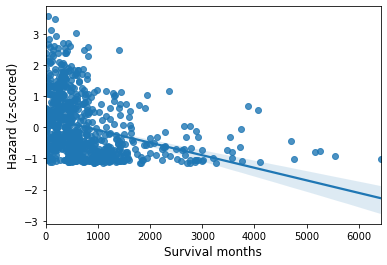

In [55]:
import seaborn as sns

sns.regplot(x='Survival months', y='Hazard (z-scored)', data=dataset)

In [32]:
dataset['5 year survival'] = np.where(dataset['Survival months'] > 5*12, 'Patient Survival > 5 years', 'Patient Survival < 5 years')

<AxesSubplot:xlabel='Hazard', ylabel='Density'>

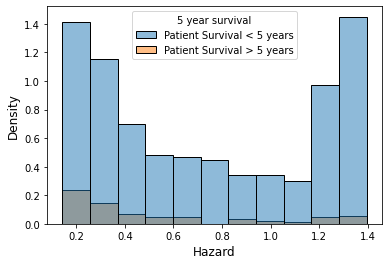

In [35]:
sns.histplot(x='Hazard', hue='5 year survival',
             data=dataset, stat="density")